In [1]:
# TCC
# Código Python para avaliação das bases de dados

# Estudo a ser avaliado: Busca prever o tempo de duração da execução de um processo
# rotina = 'Rotina_01'
# coluna = 'TempoMinutos' 

In [2]:
# Fontes:

# Ver dicas para transformação BOX-COX com Auto-Arima - exemplo completo
# https://alkaline-ml.com/pmdarima/usecases/sun-spots.html
# https://alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html

# RMSE / R2
# https://ivanildo-batista13.medium.com/autoarima-em-python-26303d650de3

# Fonte: Prof Fernando Amaral
# https://www.youtube.com/watch?v=ccupZdvYCn4

# Original está no Google Colab
# https://colab.research.google.com/

In [3]:
# Colunas existentes
#   DiaInicio
#   DtHoraInicio
#   DtHoraFim
#   Processo
#   TempoMinutos
#   TempoMinutosInicioExecucao

In [4]:
# Avaliações efetuadas
'''
Gráfico de Linhas do processo, para avaliação visual de sua distribuição
Média Móvel para avaliação visual de sazonalidades
Gráfico de Barras com médias mensais de tempos de processamento
Decomposição da Série Temporal
Dickey-Fuller Aumentado para avaliar estacionariedade
Execução do processo de diferenciação para estacionariedade
Histograma
Correlograma Total e Parcial
Normalização
Definição da base em Treino e Teste
Execução do Auto-Arima para predições
Avaliação do RMSE utilizando as predições somente da base de testes
Gerado gráfico comparativo do Real com o Predito
Efetuado teste de Teste de Ljung-Box para avaliar a normalidade dos resíduos
'''

'\nGráfico de Linhas do processo, para avaliação visual de sua distribuição\nMédia Móvel para avaliação visual de sazonalidades\nGráfico de Barras com médias mensais de tempos de processamento\nDecomposição da Série Temporal\nDickey-Fuller Aumentado para avaliar estacionariedade\nExecução do processo de diferenciação para estacionariedade\nHistograma\nCorrelograma Total e Parcial\nNormalização\nDefinição da base em Treino e Teste\nExecução do Auto-Arima para predições\nAvaliação do RMSE utilizando as predições somente da base de testes\nGerado gráfico comparativo do Real com o Predito\nEfetuado teste de Teste de Ljung-Box para avaliar a normalidade dos resíduos\n'

In [5]:
# Ignorar os Warnings
import warnings
# warnings.filterwarnings(action='once') # não ignorar warnings
warnings.filterwarnings('ignore') # ignorar warnings

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 21,6

#from scipy.stats import boxcox
#from scipy.special import inv_boxcox
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Correlogramas

from statsmodels.tsa.stattools import adfuller

In [7]:
from pmdarima.arima import auto_arima

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
df = pd.read_excel('DataFrame_Processos_Percentual_Base_CompletaAjusteOutLiers.xlsx')
df.Dtinicio = pd.to_datetime(df.DiaInicio)
df.set_index('DiaInicio', inplace=True)
df.head(3)

,DtHoraInicio,DtHoraFim,Processo,TempoMinutos,TempoMinutosInicioExecucao
DiaInicio,,,,,
2021-01-05,2021-01-05 05:21:00.000001,2021-01-05 07:40:00,Rotina_01,139,321.0
2021-01-06,2021-01-06 04:13:00.000000,2021-01-06 05:54:00,Rotina_01,101,253.0
2021-01-07,2021-01-07 03:30:00.000001,2021-01-07 05:24:00,Rotina_01,114,210.0


In [10]:
# Define base para pesquisa
rotina = 'Rotina_01'
coluna = 'TempoMinutos' # 'TempoMinutos' / 'TempoMinutosInicioExecucao'

In [11]:
df = df.loc[df['Processo']==rotina] 

# Cria Dataframe somente com as colunas que interessam
df = pd.DataFrame(df, columns = [coluna])
df.head(3)

,TempoMinutos
DiaInicio,
2021-01-05,139
2021-01-06,101
2021-01-07,114


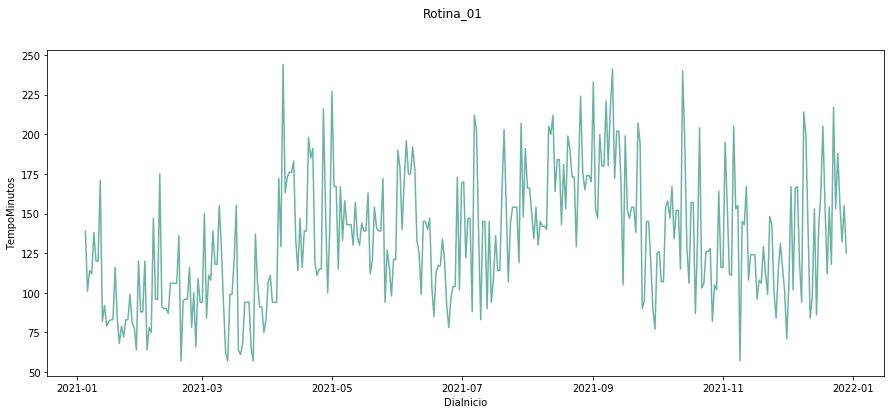

In [12]:
# Plotagem - Gráfico Linha
fig, axes = plt.subplots(figsize=(15, 6))
fig.suptitle(rotina)

# Grafico Rotina 01
sns.lineplot(data=df, x=df.index , y=coluna, ci=None, color='#69b3a2', estimator=sum)

In [13]:
#Para plotar as médias móveis para n períodos, utilizamos o comando Series.rolling(numero_de_periodos).mean().plot()

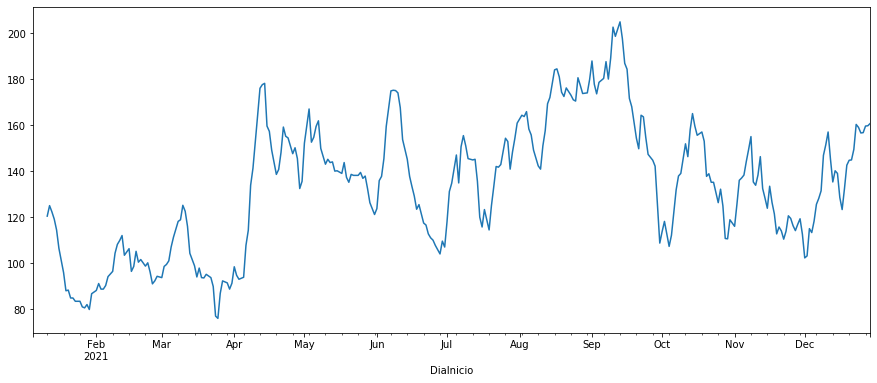

In [14]:
# Média móvel de  dias - 1 semana
df[coluna].rolling(7).mean().plot(figsize=(15, 6))

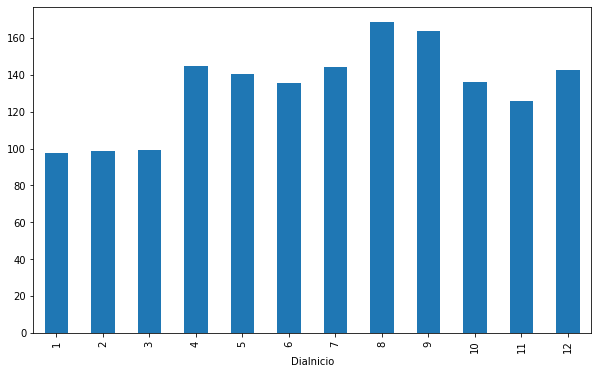

In [15]:
# Tempo médio de processamento - Gráfico barras com o tempo médio mensal de processamento
df[coluna].groupby(df.index.month).mean().plot(kind='bar', figsize=(10, 6), width=0.5)

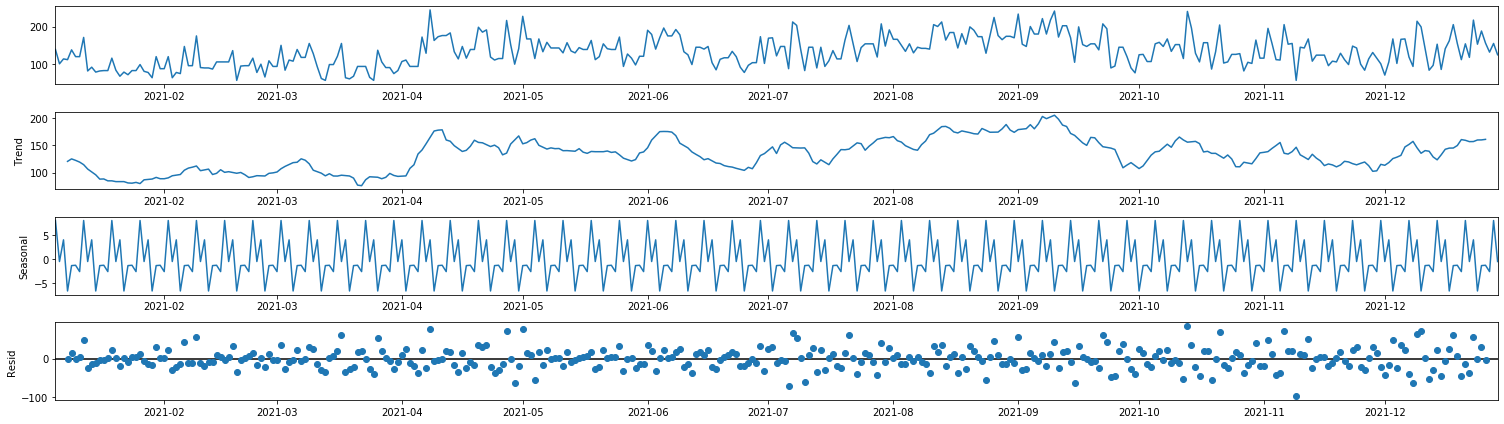

In [16]:
# Decompondo a série
import statsmodels as sm
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [16.0,9.0]

In [17]:
# Efetuar teste para avaliar se está estacionário

In [18]:
# ************* Limongi sugeriu colocar antes das análises

# Augmented Dickey-Fuller (ADF) Statistic 
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %.15f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.682064
p-value: 0.077193708063946
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [19]:
'''
Test statistic: -2.682
P-value: 0.077193708
Since the p-value is not less than .05, we fail to reject the null hypothesis.

Isso significa que a série temporal não está estacionária. Em outras palavras, tem alguma 
estrutura dependente do tempo e não tem variância constante ao longo do tempo.

Teste Augmented Dickey-Fuller
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
'''

'\nTest statistic: -2.682\nP-value: 0.077193708\nSince the p-value is not less than .05, we fail to reject the null hypothesis.\n\nIsso significa que a série temporal não está estacionária. Em outras palavras, tem alguma \nestrutura dependente do tempo e não tem variância constante ao longo do tempo.\n\nTeste Augmented Dickey-Fuller\np-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.\np-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.\n'

In [20]:
# Augmented Dickey-Fuller (ADF) Statistic - com uma diferenciação
df_diff = pd.DataFrame(df.values, columns=[coluna])
df_diff = df_diff.diff(periods=1).dropna()
result = adfuller(df_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %.15f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.525619
p-value: 0.000000000000107
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [21]:
# Com uma diferenciação o p_value passa, pois é menor que 0.05
# Não será necessário efetuar transformações com log e nem com Box_Cox

### Diferenças
# O procedimento utilizado para eliminar a tendência é conhecido na literatura como procedimento para 
# transformação de uma série não estacionária em uma série estacionária. 

#Normalmente, será necessária somente uma ou duas diferenças para que a série se torne estacionária.

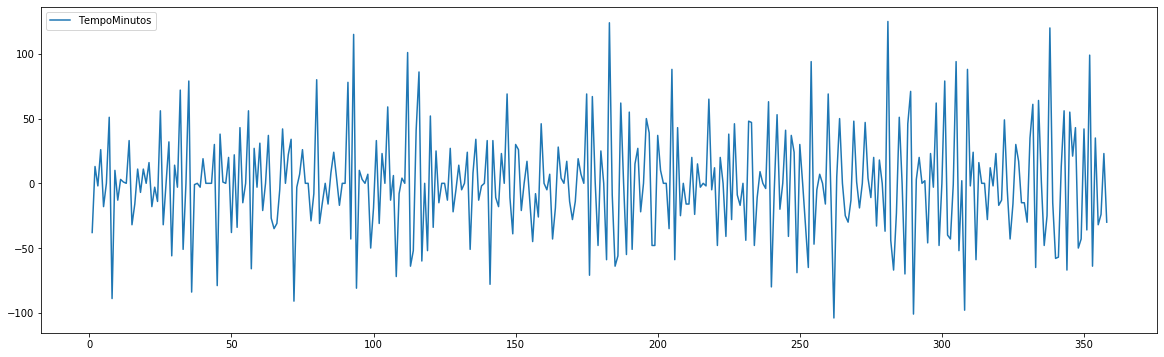

In [22]:
# Plotagem da série com diferenciação
df_diff.plot(figsize=(20, 6))

In [23]:
# Histogramas

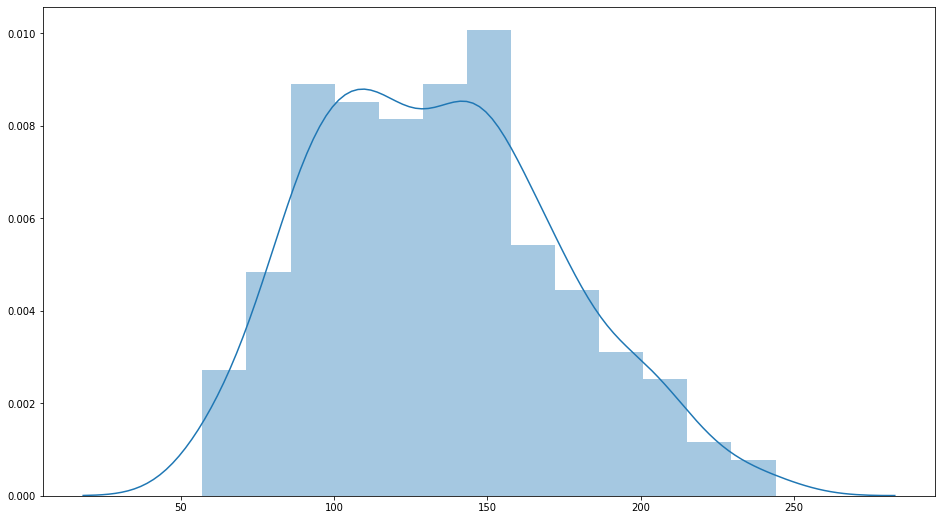

In [24]:
# Original
sns.distplot(df, hist=True, kde=True)

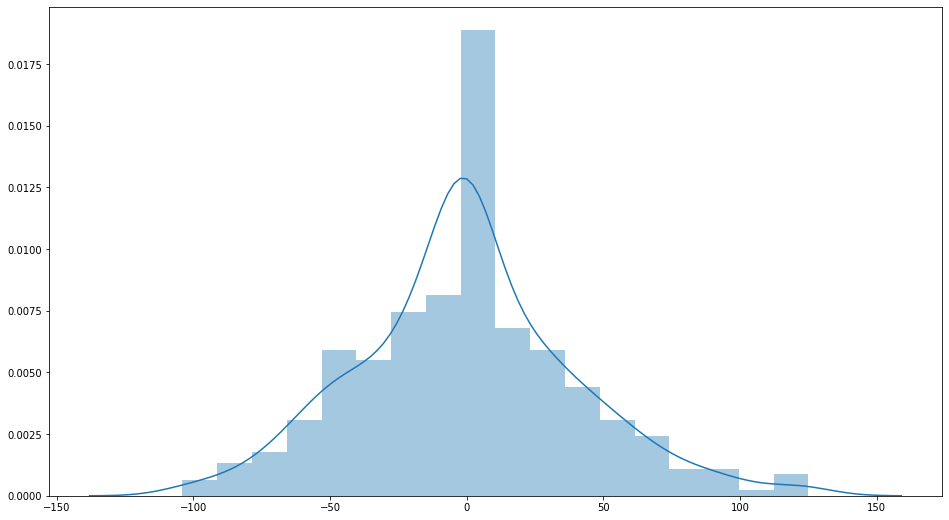

In [25]:
# Diferenciado
# plot the distribution of the transformed data values
sns.distplot(df_diff, hist=True, kde=True)

In [26]:
# Correlogramas - os pontos dentro o intervalo "em azul" são os significativos

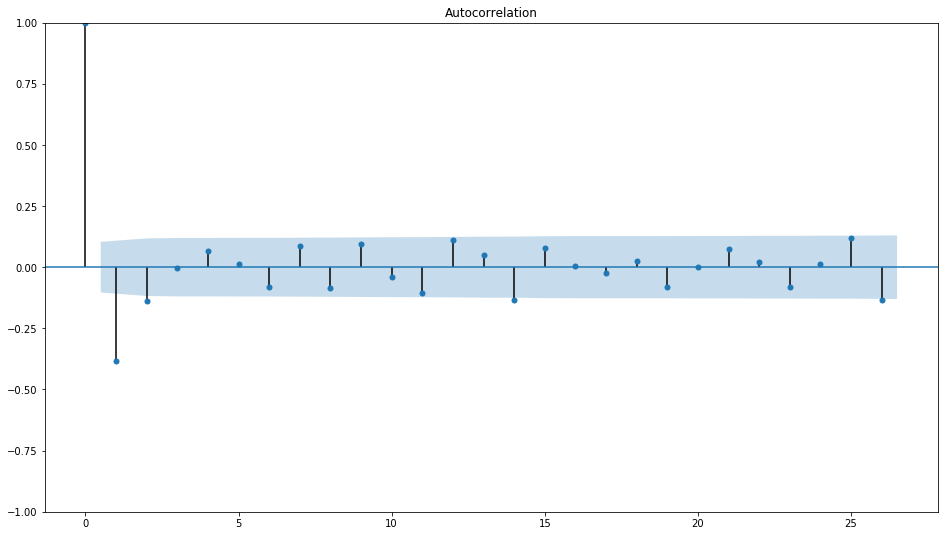

In [27]:
# AutoCorrelação Total - Com Diferenciação
plot_acf(df_diff[coluna])
plt.show()

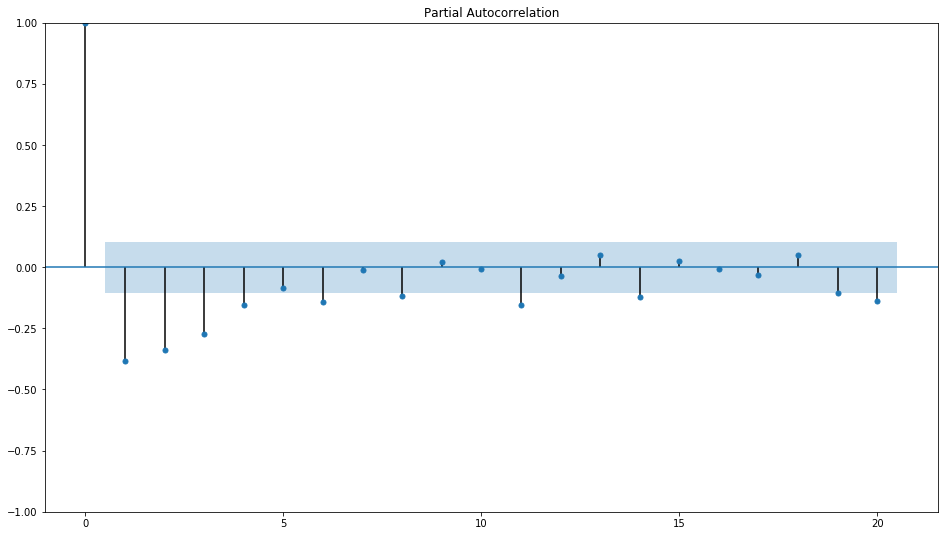

In [28]:
# AutoCorrelação Parcial - Com Diferenciação
plot_pacf(df_diff[coluna], lags=20)
plt.show()

In [29]:
# Normalização
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [30]:
# normalização a ser passada para o DataFrame
scaler.fit(df)
scaled_train = scaler.transform(df)

In [31]:
scaled_train[:2]

array([[0.43850267],
       [0.23529412]])

In [32]:
# Atualiza DataFrame com normalização
df[coluna] = scaled_train

In [33]:
df.head(2)

,TempoMinutos
DiaInicio,
2021-01-05,0.438503
2021-01-06,0.235294


In [34]:
# Para voltar o valor
scaler.inverse_transform(df[:2])

array([[139.],
       [101.]])

In [35]:
# Define tamanho da base
tamanho_base = df.count() # 359 linhas
tamanho_base

TempoMinutos    359
dtype: int64

In [36]:
# Define tamanho base Treino e Teste 
# Testes
# 2/3
# 3/4
# 4/5
# 9/10

train_size = int(tamanho_base * 9 / 10)
train_size

323

In [37]:
# Define bases de treino
train_set = df[:train_size]
train_set.head(2)

,TempoMinutos
DiaInicio,
2021-01-05,0.438503
2021-01-06,0.235294


In [38]:
# Define bases de teste
test_set = df[train_size:]
test_set.head(2)

,TempoMinutos
DiaInicio,
2021-11-24,0.459893
2021-11-25,0.229947


In [39]:
# EXECUTAR AUTO-ARIMA

In [40]:
# Com stepwise=True
train_model = auto_arima(train_set, start_p=0, start_q=0, max_p=8, max_q=11, m=12, start_P=0, seasonal=True,d=1,D=1,trace=True,error_action='ignore', suppress_warnings=True, stepwise=True, return_valid_fits=False)
# trace é para visualizar a saída
# return_valid_fits=False --> se colocar True irá retornar uma matriz com todo modelos válidos, com False retorna apenas o melhor

# Rotina_01 / TempoMinutos
# Best model 2/3:  ARIMA(4,1,0)(2,1,0)[12]
# Best model 3/4:  ARIMA(1,1,2)(2,1,0)[12] 
# Best model 4/5:  ARIMA(4,1,0)(2,1,0)[12]
# Best model 9/10: ARIMA(4,1,0)(2,1,0)[12]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=97.941, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-27.989, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=46.514, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-63.745, Time=0.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1.436, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-97.558, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-55.160, Time=0.19 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-111.508, Time=0.66 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-74.189, Time=0.

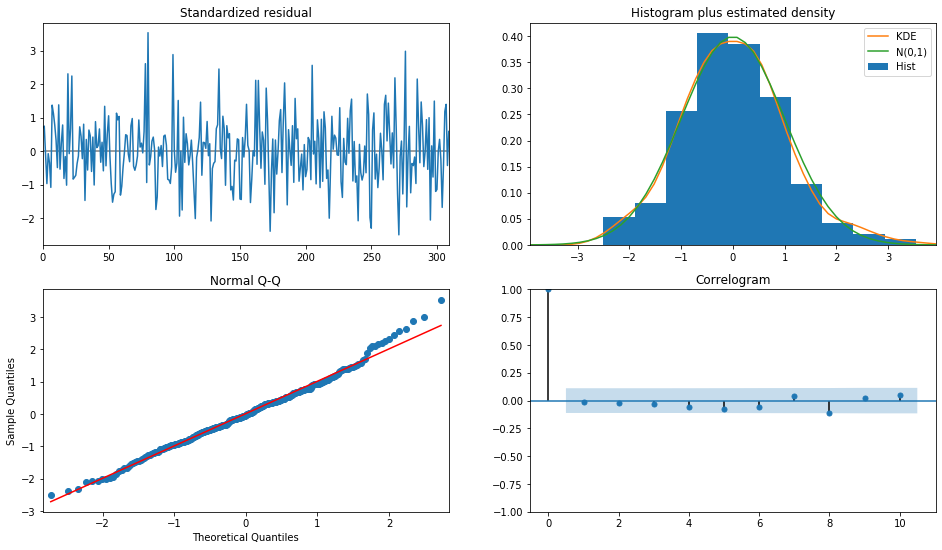

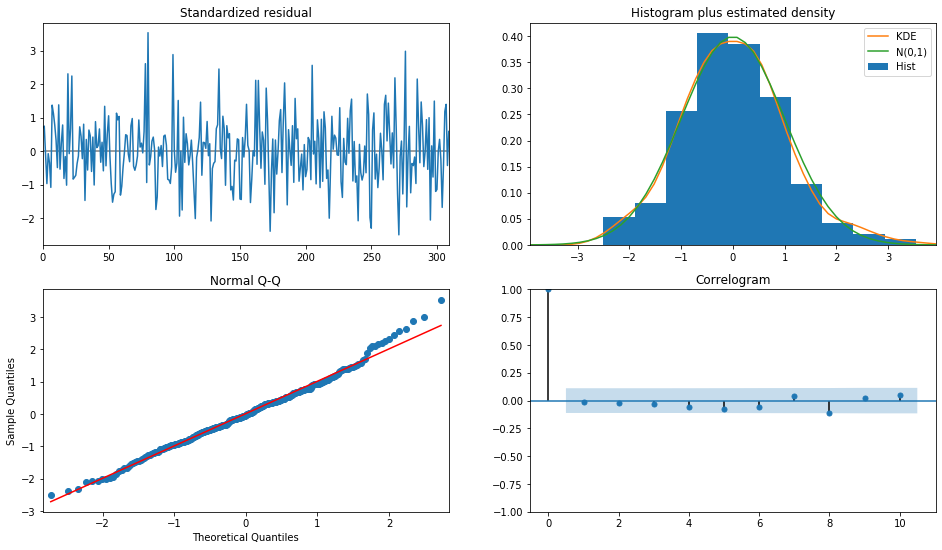

In [41]:
train_model.plot_diagnostics()

In [42]:
train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  323
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood                  64.607
Date:                            Thu, 15 Sep 2022   AIC                           -115.214
Time:                                    13:15:34   BIC                            -89.058
Sample:                                         0   HQIC                          -104.757
                                            - 323                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6843      0.062    -11.124      0.000      -0.805      -0.564
ar.L2         -0.5234      0.076     -6.851      0.000      -0.673      -0.374
ar.L3         -0.3157      0.072     -4.404      0.000      -0.456      -0.175
ar.L4         -0.1386      0.065     -2.134      0.033      -0.266      -0.011
ar.S.L12      -0.6651      0.058    -11.374      0.000      -0.780      -0.551
ar.S.L24      -0.3490      0.050     -6.978      0.000      -0.447      -0.251
sigma2         0.0377      0.003     13.450      0.000       0.032       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.85   Prob(JB):                         0.03
Heteroskedasticity (H):               1.27   Skew:                             0.30
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# CALCULAR RMSE - Avaliação do modelo
# Abaixo temos duas métricas de avaliação : o RMSE e R². A primeira é mais usada para 
# comparar entre vários modelos, onde o melhor modelo é aquele cujo valor dessa métrica 
# esteja mais próximo de zero. O segundo (R²) nos dá o quanto os valores treinados/preditos 
# estão alinhados com os valores de treino

In [44]:
# ATENÇAO - os valores foram testados todos com normalização, apenas na hora de mostrar o RMSE e R2 foram trazidos para o valor
# real e mostrados os valores - Textos COM e SEM normalização é apenas para mostrar os indicadores

In [45]:
# Base = 359    # Treino = 239     # Teste = 359 - 239 = 120 
tamanho_base_teste = int(test_set.count()) # Necessário converter para int pois dava erro na linha abaixo por estar como Int64
print(tamanho_base_teste)

# Efetua a predição em cima dos valores da base teste
future_forecast = train_model.predict(n_periods=tamanho_base_teste) 

# Convert future_forecast para DataFrame
future_forecast = pd.DataFrame(future_forecast, index=test_set.index, columns=[coluna])

36


In [46]:
future_forecast.head(5)

,TempoMinutos
DiaInicio,
2021-11-24,0.301174
2021-11-25,0.296446
2021-11-26,0.582768
2021-11-27,0.307464
2021-11-28,0.255439


In [47]:
# Retorna valores sem a normalização - escala original
future_forecast = scaler.inverse_transform(future_forecast)
test_set[coluna] = np.reshape(scaler.inverse_transform([test_set[coluna]]), (tamanho_base_teste,1))

In [48]:
print("Sem normalização")
print("RMSE do modelo : %.3f" % np.sqrt(mean_squared_error(test_set, future_forecast)))
print("R² do modelo : %.3f" % r2_score(test_set, future_forecast))

Sem normalização
RMSE do modelo : 52.073
R² do modelo : -0.881


In [49]:
'''
Com 2/3
RMSE do modelo : 105.987
R² do modelo : -6.140

Com 3/4
RMSE do modelo : 141.713
R² do modelo : -14.978

Com 4/5
RMSE do modelo : 56.052
R² do modelo : -1.483

Com 9/10
RMSE do modelo : 52.073
R² do modelo : -0.881 
'''

'\nCom 2/3\nRMSE do modelo : 105.987\nR² do modelo : -6.140\n\nCom 3/4\nRMSE do modelo : 141.713\nR² do modelo : -14.978\n\nCom 4/5\nRMSE do modelo : 56.052\nR² do modelo : -1.483\n\nCom 9/10\nRMSE do modelo : 52.073\nR² do modelo : -0.881 \n'

In [50]:
# Avaliar comportamento do modelo na base de teste

In [51]:
test_set.head(2), test_set.tail(2)

(            TempoMinutos
 DiaInicio               
 2021-11-24         143.0
 2021-11-25         100.0,
             TempoMinutos
 DiaInicio               
 2021-12-28         155.0
 2021-12-29         125.0)

In [52]:
future_forecast.shape

(36, 1)

In [53]:
# Ajusta valores para geração do gráfico

In [54]:
# Convert future_forecast para DataFrame
future_forecast = pd.DataFrame(future_forecast, index=test_set.index, columns=['TempoPredito'])

In [55]:
future_forecast.head(2), future_forecast.tail(2)

(            TempoPredito
 DiaInicio               
 2021-11-24    113.319631
 2021-11-25    112.435479,
             TempoPredito
 DiaInicio               
 2021-12-28     94.366464
 2021-12-29    132.419300)

In [56]:
# Efetua conversão do valor
train_set[coluna] = np.reshape(scaler.inverse_transform([train_set[coluna]]), (train_size,1))

In [57]:
 df, train_set, test_set, future_forecast

(            TempoMinutos
 DiaInicio               
 2021-01-05         139.0
 2021-01-06         101.0
 2021-01-07         114.0
 2021-01-08         112.0
 2021-01-09         138.0
 ...                  ...
 2021-12-25         188.0
 2021-12-26         156.0
 2021-12-27         132.0
 2021-12-28         155.0
 2021-12-29         125.0
 
 [359 rows x 1 columns],
             TempoMinutos
 DiaInicio               
 2021-01-05         139.0
 2021-01-06         101.0
 2021-01-07         114.0
 2021-01-08         112.0
 2021-01-09         138.0
 ...                  ...
 2021-11-19         106.0
 2021-11-20         129.0
 2021-11-21         112.0
 2021-11-22          99.0
 2021-11-23         148.0
 
 [323 rows x 1 columns],
             TempoMinutos
 DiaInicio               
 2021-11-24         143.0
 2021-11-25         100.0
 2021-11-26          84.0
 2021-11-27         114.0
 2021-11-28         131.0
 2021-11-29         116.0
 2021-11-30         101.0
 2021-12-01          71.0
 2021-12-0

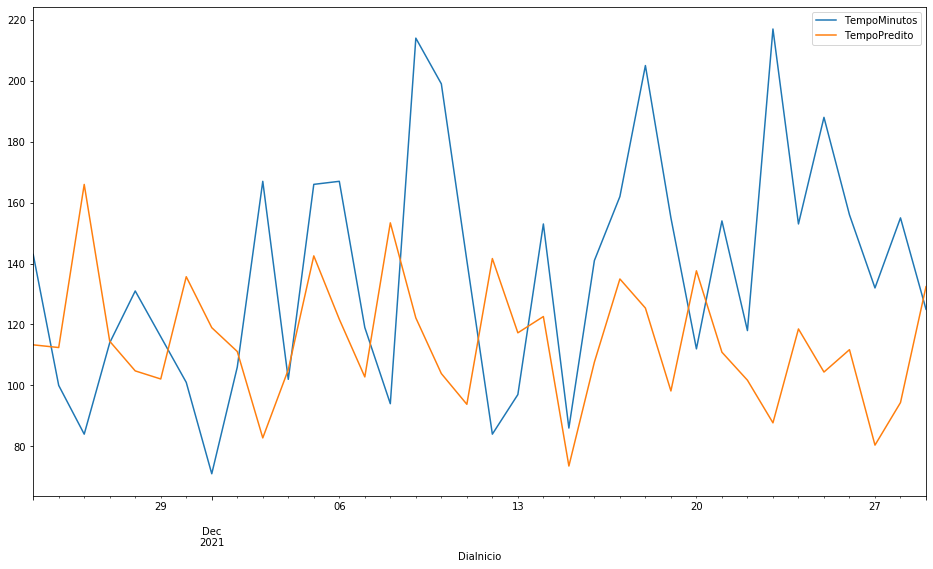

In [58]:
pd.concat([test_set, future_forecast], axis=1).plot()

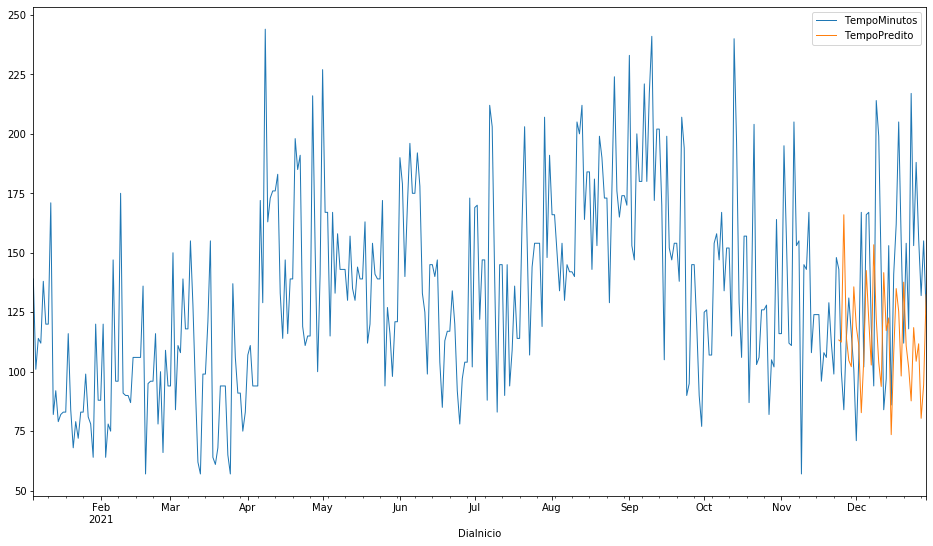

In [59]:
pd.concat([df, future_forecast], axis=1).plot(linewidth=1)

In [60]:
# Teste de Ljung-Box – VERIFICAR A NORMALIDADE DOS RESÍDUOS 

# Teste Ljung–Box: determina se algum grupo de autocorrelações de uma série 
# temporal é diferente de zero. Em outras palavras, avaliar se as séries de 
# observações ao longo do tempo é aleatória e independente, normalmente 
# distribuídos com média zero e variância constante.

# H0: independência da Série Temporal, isto é, resíduos não correlacionados no tempo
# H1: dependência da Série Temporal, isto é, resíduos correlacionados, indicando que o modelo 
# não capturou alguma estrutura que indica um erro sistemático
# Teste de Ljung-Box - p-valor < 0,05 - Rejeição de H0
# O ideal é não rejeitar a hipótese nula, ou seja, p_value deve ser >= 0.05

In [61]:
import statsmodels.api as sm

In [62]:
sm.stats.acorr_ljungbox(train_model.resid(), lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,13.424558,0.200893


In [63]:
# Segundo Morettin e Toloi (2004), basta utilizar entre 10 e 15 primeiras autocorrelações
# Ver documentação
# Conforme acima passou nos 2 casos, com 10 e 15 lags

In [64]:
# Lista os testes até "x" lags
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
re = lb_test(train_model.resid(), lags=15) 
print(re)

      lb_stat  lb_pvalue
1    0.375323   0.540117
2    0.520442   0.770881
3    0.859501   0.835189
4    1.617159   0.805705
5    4.170271   0.525171
6    5.818826   0.443788
7    7.838714   0.347031
8   12.629370   0.125254
9   12.734753   0.174980
10  13.424558   0.200893
11  16.527496   0.122650
12  17.182171   0.142872
13  17.864045   0.162750
14  19.197771   0.157529
15  21.598062   0.118784


In [ ]:
# Avaliação para o TCC - Simulação para o dia 15/12

In [70]:
test_set.tail(15), future_forecast.tail(15)

(            TempoMinutos
 DiaInicio               
 2021-12-15          86.0
 2021-12-16         141.0
 2021-12-17         162.0
 2021-12-18         205.0
 2021-12-19         155.0
 2021-12-20         112.0
 2021-12-21         154.0
 2021-12-22         118.0
 2021-12-23         217.0
 2021-12-24         153.0
 2021-12-25         188.0
 2021-12-26         156.0
 2021-12-27         132.0
 2021-12-28         155.0
 2021-12-29         125.0,
             TempoPredito
 DiaInicio               
 2021-12-15     73.535971
 2021-12-16    107.642683
 2021-12-17    134.943802
 2021-12-18    125.390544
 2021-12-19     98.178708
 2021-12-20    137.627294
 2021-12-21    110.902656
 2021-12-22    101.708044
 2021-12-23     87.716431
 2021-12-24    118.539184
 2021-12-25    104.392307
 2021-12-26    111.733725
 2021-12-27     80.400361
 2021-12-28     94.366464
 2021-12-29    132.419300)